# Programming Assignment: Размещение баннеров

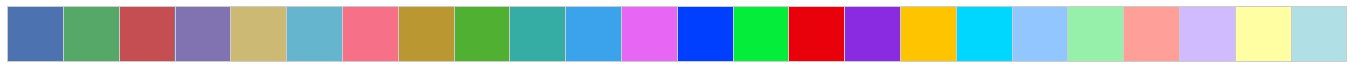

In [17]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from contextlib import contextmanager

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

## Problem

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

## Get data

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsq.zip с этой страницы.

In [18]:
import os.path
import requests
from zipfile import ZipFile

def fetch_file(url, filename):
    if os.path.exists(filename):
        return
    response = requests.get(url, stream=True)
    with open(filename, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)            

def extract_zip(from_path, to_path):
    with ZipFile(from_path, 'r') as zip_ref:
        zip_ref.extractall(to_path)
        
def fetch_data():
    if os.path.exists('data/02_checkins.csv'):
        return
    
    # download zip dataset to temp
    tmp_path = os.path.expanduser('~/AppData/Local/Temp/')
    dataset_zip = os.path.join(tmp_path, 'foursquare_dataset.zip')
    fetch_file('https://archive.org/download/201309_foursquare_dataset_umn/fsq.zip', dataset_zip)
    
    # extract zip
    extracted_data_path = os.path.join(tmp_path, 'foursquare_dataset')
    extract_zip(dataset_zip, extracted_data_path)
    
    # read, clean, save to `data` folder
    extracted_data_path = os.path.join(tmp_path, 'foursquare_dataset/umn_foursquare_datasets/checkins.dat')
    data = pd.read_csv(extracted_data_path, sep='|', low_memory=False, skiprows=[1], skipinitialspace=True, usecols=[3, 4])
    data.dropna(inplace=True)
    data.columns = [col.strip() for col in data.columns]

    data.to_csv('data/02_checkins.csv')
    
fetch_data()

Нас будет интересовать файл checkins.dat. Открыв его, увидим следующую структуру:

In [19]:
data = pd.read_csv('data/02_checkins.csv')
print(data.shape)
data.head()

(396634, 3)


,ind,latitude,longitude
0,1,38.895112,-77.036366
1,3,33.800745,-84.410520
2,7,45.523452,-122.676207
3,9,40.764462,-111.904565
4,10,33.448377,-112.074037


In [20]:
from sklearn import metrics, model_selection as mdsel, cluster

In [37]:
clusterizer = cluster.MeanShift(bandwidth=0.1)

In [39]:
%%time
data_slice = data.loc[:100000, ['latitude', 'longitude']].values
clusterizer.fit(data_slice)

Wall time: 4min 38s


In [40]:
clusterizer.labels_[:10]

array([ 5,  7, 30, 65,  1, 23,  0,  1,  2,  8], dtype=int64)

In [101]:
np.max(clusterizer.labels_)

3230

In [158]:
from itertools import groupby
from operator import itemgetter

def get_centroid(cluster):
    points = data_slice[cluster]
    return np.mean(points, axis=0)

clusters = [(cl, i) for i, cl in enumerate(clusterizer.labels_)]
clusters.sort()

clusters = [
    (key, points)
    for key, group in groupby(clusters, key=itemgetter(0))
    for points in [[p[1] for p in group]]
    if len(points) > 15
]

print(len(clusters))
print(clusters[500])

592
(504, [15234, 20945, 25257, 38753, 39429, 40714, 44482, 50618, 58205, 70155, 70813, 76463, 79370, 95139, 95173, 95226, 95361, 95755, 95857, 96098, 96109])


In [159]:
offices = np.array([
    [33.751277, -118.188740],
    [25.867736, -80.324116],
    [51.503016, -0.075479],
    [52.378894, 4.885084],
    [39.366487, 117.036146],
    [-33.868457, 151.205134],
])

In [168]:
centroids = np.array([get_centroid(points) for key, points in clusters])
distances = metrics.euclidean_distances(centroids, offices)
min_cluster_distances = np.min(distances, axis=1)

result = [
    (clusters[i][0], dist, centroids[i])
    for i, dist in enumerate(min_cluster_distances)
]

result.sort(key=itemgetter(1))
result[:20]
# clusters.sort(key=itemgetter(2))

[(420, 0.007834758333930724, array([-33.86063043, 151.20477593])),
 (370, 0.00935331618447212, array([52.37296399,  4.89231722])),
 (419, 0.022674066155853188, array([ 25.84567226, -80.3188906 ])),
 (58, 0.048713889715287936, array([51.50278627, -0.12419235])),
 (51, 0.06383757737918763, array([  33.80577421, -118.1554941 ])),
 (29, 0.13594306076638893, array([ 25.79004924, -80.21255757])),
 (167, 0.17295887548786643, array([ 25.69899723, -80.2861423 ])),
 (92, 0.18505412385140863, array([ 26.00644659, -80.20162355])),
 (87, 0.18802946105762436, array([  33.86452949, -118.03864353])),
 (42, 0.20618640321704054, array([  33.86473197, -118.36090504])),
 (291, 0.22111584180740923, array([  33.97140437, -118.16785564])),
 (320, 0.27130075950710053, array([ 26.13884379, -80.33434684])),
 (32, 0.28239201356973725, array([  33.66901693, -117.91859461])),
 (27, 0.30045490978667017, array([  33.83128033, -117.8991323 ])),
 (11, 0.3058042209309342, array([  34.05210412, -118.24368782])),
 (119, 

In [179]:
def write_answer(result, ans_ind):
    path = f'out/02_banners{ans_ind}.txt'
    result_str = result if isinstance(result, str) else str(result)
    with open(path, "w") as fout:
        fout.write(result_str)
        
answer1 = result[0][2]
answer1 = str.join(' ', map(str, answer1))
print(answer1)
write_answer(answer1, 1)

-33.86063042857143 151.20477592857145
